In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import matplotlib.patches as mpatches
import cartopy
from datetime import timedelta as delta
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import xarray as xr
from os import environ
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In [5]:
# exp = 'china'
# exp = 'fwd'
exp = 'bwd'

In [30]:
galapagos_extent = [-91.8, -89, -1.4, 0.7]
environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

# pfile = xr.open_dataset('galapagosparticles_fwd_2yrs.nc', decode_cf=True)
pfile = xr.open_dataset('/scratch/evansebille/galapagosparticles_%s.nc' %exp, decode_cf=True)
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
age = np.ma.filled(pfile.variables['age'], np.nan)

if exp != 'bwd':
    visitedgalapagos = np.ma.filled(pfile.variables['visitedgalapagos'], np.nan)
else:
    visitedgalapagos = np.ones(lat.shape)
pfile.close()

if exp != 'bwd':
    visitedtime = np.nan*np.zeros(visitedgalapagos.shape[0])
    for p in range(visitedgalapagos.shape[0]):
        if np.any(visitedgalapagos[p, :] == 1):
            I = np.where(visitedgalapagos[p, :] == 1)[0][0]
            visitedtime[p] = age[p, I]/86400.
            visitedgalapagos[p, :] = 1
    nvisited = len(np.where(visitedgalapagos[:, 0]==1)[0])
        
nsites = np.unique(lat[:, 0]).shape[0]
startsite = np.nan*np.zeros(lat.shape[0])
for s in range(nsites):
    I = np.where(lat[:, 0] == lat[s, 0])
    startsite[I] = s

In [ ]:
pylab.rcParams['figure.figsize'] = (10, 7)

if np.any(np.isfinite(visitedtime)):
    plt.hist(visitedtime[np.isfinite(visitedtime)], np.arange(0, np.nanmax(visitedtime), 10))
    plt.gca().set_xlim([0, np.nanmax(visitedtime)])
    plt.xlabel('Time to first pass through Galapagos [days]')
    plt.ylabel('Number of particles')
    plt.title('%d of %d (%.1f%%) particles reach Galapagos' % (nvisited, visitedgalapagos.shape[0],
          100.0*nvisited/visitedgalapagos.shape[0]))
    plt.show()

In [ ]:
countrylats = [-60, -18, -3, 1.5, 7.3, 8.1, 11.0, 12.8, 13.7, 14.6, 32.5]
countrynames = ['CH', 'PE', 'EC', 'CO', 'PA', 'CR', 'NI', 'SV', 'GT', 'MX']

In [ ]:
pct_visitgalapagos = np.zeros(nsites)
startlat = np.zeros(nsites)
for s in range(nsites):
    I = np.where(startsite==s)[0]
    nvisit = len(np.where(visitedgalapagos[I,0]==1)[0])
    pct_visitgalapagos[s] = 100*nvisit/len(I)
    startlat[s] = lat[I[0], 0]

plt.plot(startlat, pct_visitgalapagos,'.-')
plt.xlabel('Starting latitude [degrees N]')
plt.ylabel('Fraction of particles passing through Galapagos [%]')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
for s in range(1, len(countrylats)):
    plt.plot([countrylats[s], countrylats[s]], ylim, 'k:')
    xmin = max(xlim[0], countrylats[s-1])
    xmax = min(xlim[1], countrylats[s])
    plt.text((xmin+xmax)/2, ylim[1]-3, countrynames[s-1], horizontalalignment='center')

plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

/home/staff/sebil001/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
/home/staff/sebil001/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.


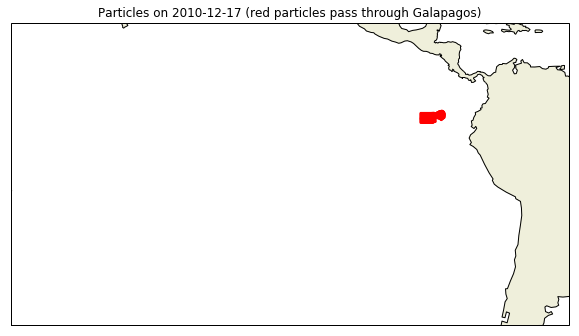

In [31]:
pylab.rcParams['figure.figsize'] = (10, 7)

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)

ax.add_patch(mpatches.Rectangle(xy=[galapagos_extent[0], galapagos_extent[2]],
                                width=galapagos_extent[1]-galapagos_extent[0], 
                                height=galapagos_extent[3]-galapagos_extent[2], facecolor='red', alpha=0.2,
                                transform=cartopy.crs.PlateCarree()))

if exp == 'americas':
    axextent = [0, 120, -15, 15]
elif exp == 'china':
    axextent = [-90, 120, -20, 50] 
elif exp == 'bwd':
    axextent = [0, 120, -45, 20] 
plottimes = np.arange(np.min(time), np.max(time), dtype='datetime64[5D]')

b = np.where(np.logical_and(time >= plottimes[0], time < plottimes[1]))
scat = ax.scatter(lon[b], lat[b], s=3, c=visitedgalapagos[b], transform=cartopy.crs.Geodetic(), cmap="bwr")
ax.set_extent(axextent, crs=projection)
scat.set_clim(0, 1)

ttl = ax.set_title('Particles on ' + str(plottimes[0]) + ' (red particles pass through Galapagos)')
frames = np.arange(0, len(plottimes)-1)

def animate(t):
    b = np.where(np.logical_and(time >= plottimes[t], time < plottimes[t+1]))
    scat.set_offsets(np.vstack((lon[b], lat[b])).transpose())
    scat.set_array(visitedgalapagos[b])
    ttl.set_text('Particles on ' + str(plottimes[t]) + ' (red particles pass through Galapagos)')
    return scat,

ax.set_extent(axextent, crs=projection)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
anim
anim.save('galapagosparticles_%s.gif' % exp, writer='imagemagick', fps=10)

In [ ]:
projection = cartopy.crs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})

axextent = [-70, 110, -20, 50]
ax.set_extent(axextent, crs=projection)

In [29]:
np.amin(time)

numpy.datetime64('2008-09-30T12:00:00.000000000')